### Autokeras

        Código

#### Librerias

In [ ]:
!pip install autokeras

In [2]:
import autokeras as ak
import sys, os, zipfile, glob, cv2
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import h5py, keras
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras import optimizers
#from keras import regularizers
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose, DepthwiseConv2D
#from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential,Input,Model,load_model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adagrad, Adam

#from tensorflow import keras
#from tensorflow.keras import layers

Mounted at /content/drive


#### Base de datos

In [3]:
path_h5 = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/'

In [4]:
!wget --no-check-certificate \
   https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0\
   -O cats_and_dogs_small.zip

local_zip = 'cats_and_dogs_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

--2022-03-28 04:21:29--  https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip [following]
--2022-03-28 04:21:30--  https://www.dropbox.com/s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc12e32305106c4442607b3243fc.dl.dropboxusercontent.com/cd/0/inline/BiQS-S0wrWoPxr24ka_W9GHYKf2cKFF43K71Nw_HQ7D2niHklVaPp6YTMXCNTUiybkGokG5vcrGc8bzjDRvLvL2ovVrJaDyq07Y32s4mxcaVL8uSeD76vvTTkbwrZ__Hqtt7F1kJiE5AGJa-TxCv1n7IazraUW3rj7qB6S2YH0J8nA/file# [following]
--2022-03-28 04:21:30--  https://uc12e32305106c4442607b3243fc.dl.dropboxusercontent.com/cd/0/inline/BiQS-S0wrWoPxr24ka_W9GHYKf2

#### Preprocesamiento

In [5]:
# Lectura de imagenes
categorias = ['cats', 'dogs']
X = []
Y = []
for categoria in tqdm(categorias):  
  ruta_imgs = glob.glob('./cats_and_dogs_small/'+ categoria +'/*.jpg')
  for ruta_img in ruta_imgs:
    img = cv2.resize(cv2.imread(ruta_img), (150, 150))
    X.append(img)
    if categoria == 'cats':
      Y.append(0)
    else:
      Y.append(1)

# Asignacion de variables X e Y
X = np.asarray(X).astype('uint8')
Y = np.expand_dims(np.asarray(Y).astype('uint8'),axis =1)
#print(type(X[0,0,0,0]), X.shape)
#print(type(Y[0,0]), Y.shape)
#print(len(X))
#print(len(Y))
#print(Y)

# Aleatorizar variables
X,Y = shuffle(X,Y)
#print(Y)

# Escritura y lectura de archivo HDF5
with h5py.File(path_h5 + 'dataset_cat_dogs.hdf5', 'w') as hf:
    x = hf.create_dataset('X', data = X, shape = X.shape, compression = 'gzip', compression_opts = 9,chunks = True)
    y = hf.create_dataset('Y', data = Y, shape = Y.shape, compression = 'gzip', compression_opts = 9,chunks = True)

with h5py.File(path_h5 + 'dataset_cat_dogs.hdf5', 'r') as hf:
    X = hf['X'][:]
    Y = hf['Y'][:]
#print('Conjunto de datos en X:',X.shape)
#print('Conjunto de datos en Y:',Y.shape)

# Normalizacion
X=X.astype('float32')
X/=255.0
#Y = to_categorical(Y)

# Regla 60/20/20
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.75)
#print( x_train.shape, x_val.shape, x_test.shape)
#print( y_train.shape, y_val.shape, y_test.shape)

100%|██████████| 2/2 [00:16<00:00,  8.29s/it]


#### Autokeras

In [6]:
clf = ak.ImageClassifier(overwrite=True, max_trials=3)

In [7]:
clf.fit(x_train, y_train, epochs=3)

Trial 3 Complete [00h 06m 16s]
val_loss: 0.5880367159843445

Best val_loss So Far: 0.5782447457313538
Total elapsed time: 00h 07m 57s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
75/75 [==============================] - 3s 34ms/step - loss: 0.7730 - accuracy: 0.5508
Epoch 2/3
75/75 [==============================] - 3s 34ms/step - loss: 0.5728 - accuracy: 0.6954
Epoch 3/3
75/75 [==============================] - 3s 35ms/step - loss: 0.3926 - accuracy: 0.8338
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


In [8]:
predicted_y = clf.predict(x_test)
print(clf.evaluate(x_test, y_test))

25/25 [==============================] - 1s 14ms/step - loss: 0.5662 - accuracy: 0.7075
[0.5662453174591064, 0.7074999809265137]


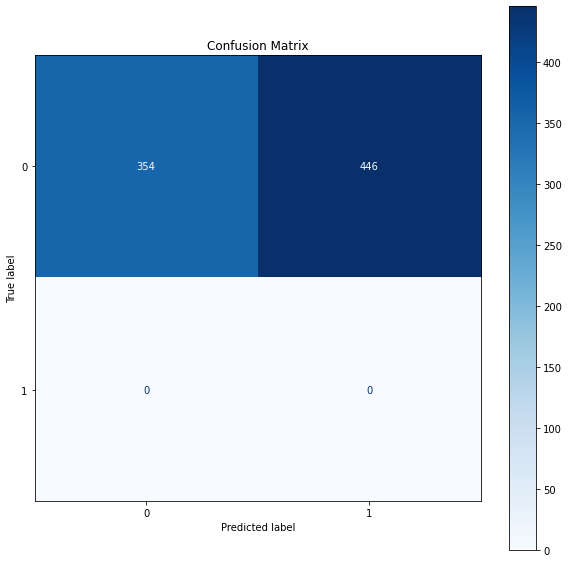

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.show()

In [16]:
reporte = classification_report(np.argmax(y_test, axis=1), predicted_y,target_names = categorias)
print(reporte)

              precision    recall  f1-score   support

        cats       1.00      0.44      0.61       800
        dogs       0.00      0.00      0.00         0

    accuracy                           0.44       800
   macro avg       0.50      0.22      0.31       800
weighted avg       1.00      0.44      0.61       800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
puntaje_test = clf.evaluate(x_test,y_test)
print('La mejor precisión probada en test es: ', 100*max(puntaje_test))
puntaje_val = clf.evaluate(x_val,y_val)
print('La mejor precisión probada en validation es: ', 100*max(puntaje_val))

25/25 [==============================] - 1s 13ms/step - loss: 0.5662 - accuracy: 0.7075
La mejor precisión probada en test es:  70.74999809265137
25/25 [==============================] - 1s 14ms/step - loss: 0.5991 - accuracy: 0.6950
La mejor precisión probada en validation es:  69.49999928474426


In [10]:
model = clf.export_model() 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 150, 150, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 150, 150, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0     

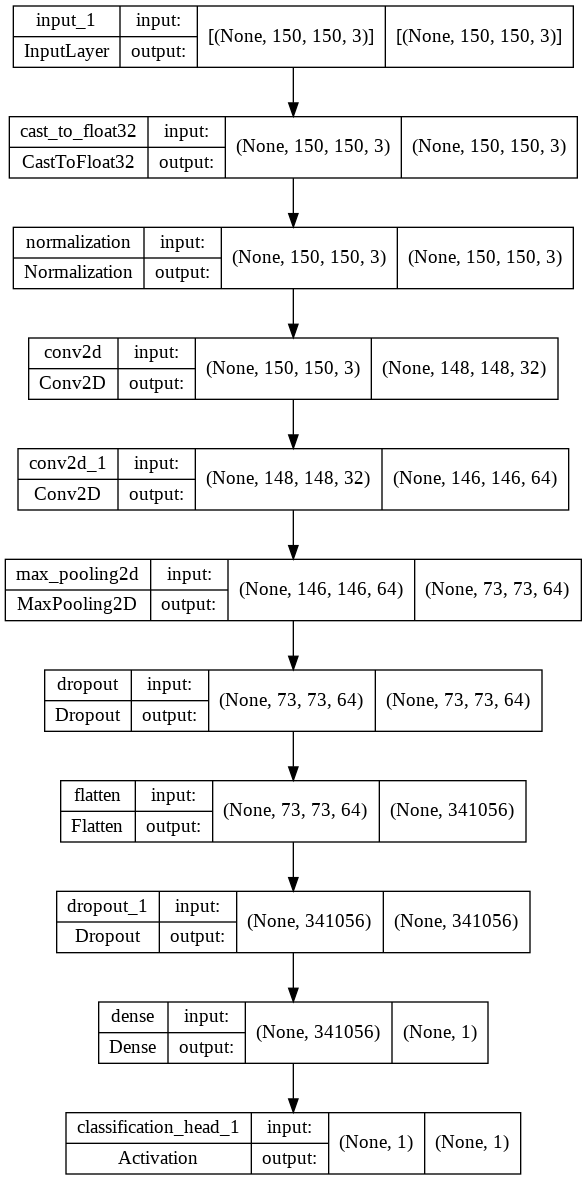

In [11]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

#Referencias

[1] AutoKeras(s.f)Modelo de exportación. Recuperado el 25 de Marzo del 2022 de https://autokeras.com/tutorial/export/

[2] Castilla Gill, C. (2021) Identificación y análisis de las principales tecnologías de AutoML. Recuperación 25 de Marzo de 2022 de https://riull.ull.es/xmlui/bitstream/handle/915/25418/Identificacion%20y%20analisis%20de%20las%20principales%20tecnologias%20de%20AutoML.pdf?sequence=1